In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import ast
import os
import sys
import pymc as pm
import pandas as pd

from pathlib import Path

lib_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'lib'))
print("Lib path:", lib_path)

# Append the absolute path to sys.path
sys.path.append(lib_path)

# Now, try importing onedmodel
from onedmodel import *

Lib path: /Users/guime/projects/SLTforSGD/code/lib


In [2]:
# Plotting settings
plt.style.use('ggplot')
fig_width = 25  # figure width in cm
inches_per_cm = 0.393701               # Convert cm to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width*inches_per_cm  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
label_size = 14
tick_size = 12
params = {'backend': 'ps',
          'lines.linewidth': 1.5,
          'axes.labelsize': label_size,
          'axes.titlesize': label_size,
          'font.size': label_size,
          'legend.fontsize': tick_size,
          'xtick.labelsize': tick_size,
          'ytick.labelsize': tick_size,
          'text.usetex': False,
          'figure.figsize': fig_size,
          "font.weight": "bold",
          "axes.labelweight": "bold"}
plt.rcParams.update(params)

# 1D case

In [48]:
# Initialise
nSGD = 10**2
nsamples = 10**4
shuffle = True
batch_size= 20
momentum = 0.5
lr = 0.01
w0 = 2.0
seed_init = 1
seed_data = 1
nw0 = 2
d1 = 2
d2 = 3
wmax = nw0 * w0
frac_max = 10**-3
model = PolyModel(w0=w0, seed=seed_init, wmax=wmax, wmin=-wmax, d1=d1,d2=d2)
sgd_runner = SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, momentum=momentum, seed=seed_data, shuffle=shuffle, 
                           batch_size=batch_size, auto=True)
df = sgd_runner.generate_trajectories(model)

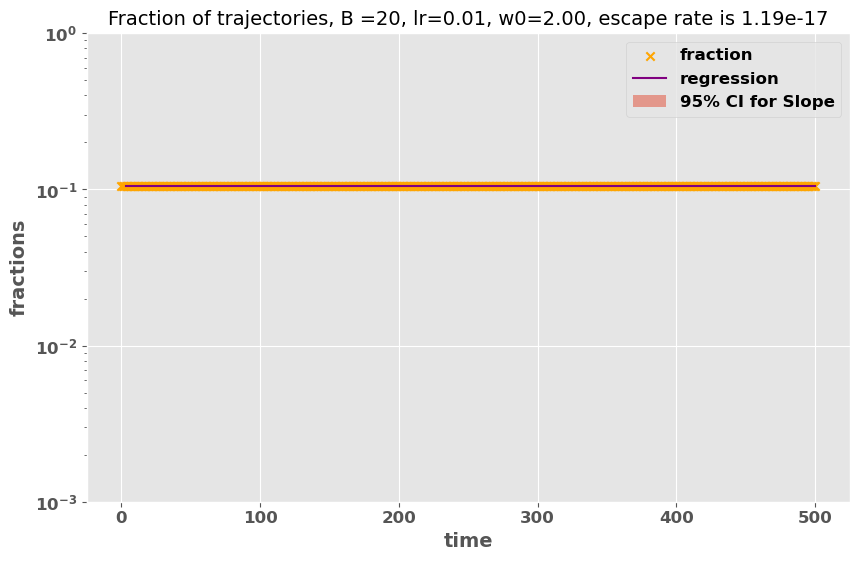

In [49]:
%matplotlib inline
trajectories = np.asarray(df['trajectory'].to_list())
clean_traj = trajectories[~np.isnan(trajectories).any(axis=1)]
fraction = regular_fraction(clean_traj, model)
escape_rate, error = compute_escape_rate(fraction, frac_max=frac_max, tmin=3,
                            batch_size=batch_size, lr=lr, w0=w0)

In [35]:
print(clean_traj.shape)
print(fraction.shape)

(137, 501)
(501,)


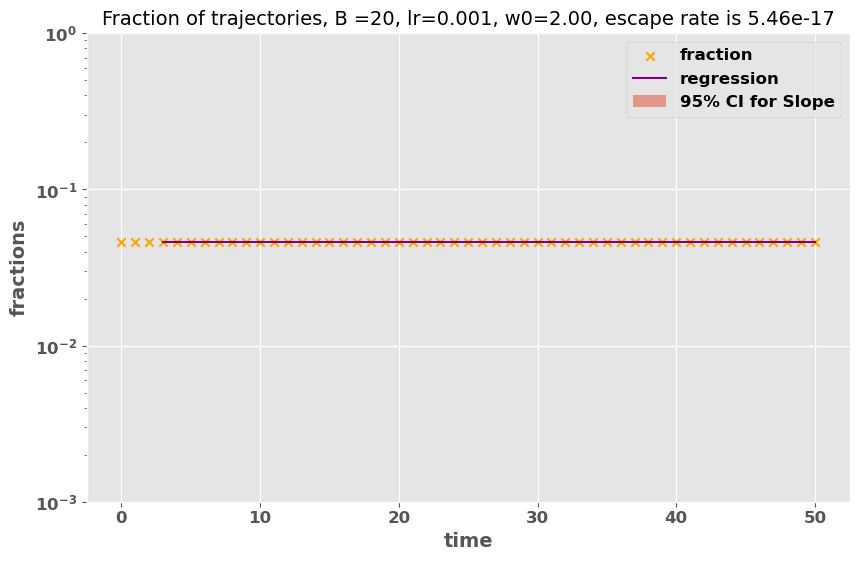

In [10]:
df_clean = df.dropna()
trajectories = np.asarray(df_clean['trajectory'].to_list())
fraction = regular_fraction(trajectories, model)
escape_rate, error = compute_escape_rate(fraction, frac_max=frac_max, tmin=3,
                            batch_size=batch_size, lr=lr, w0=w0)

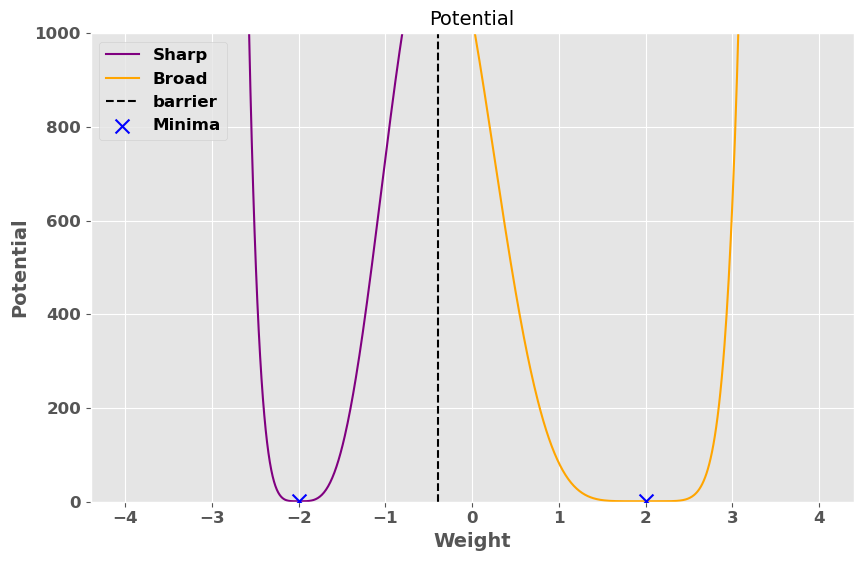

In [84]:
plot_potential(model, nsamp = 10**4, ymax = 1000)

Text(0.5, 1.0, 'Distribution of SGD trajectories after 500.0 iterations')

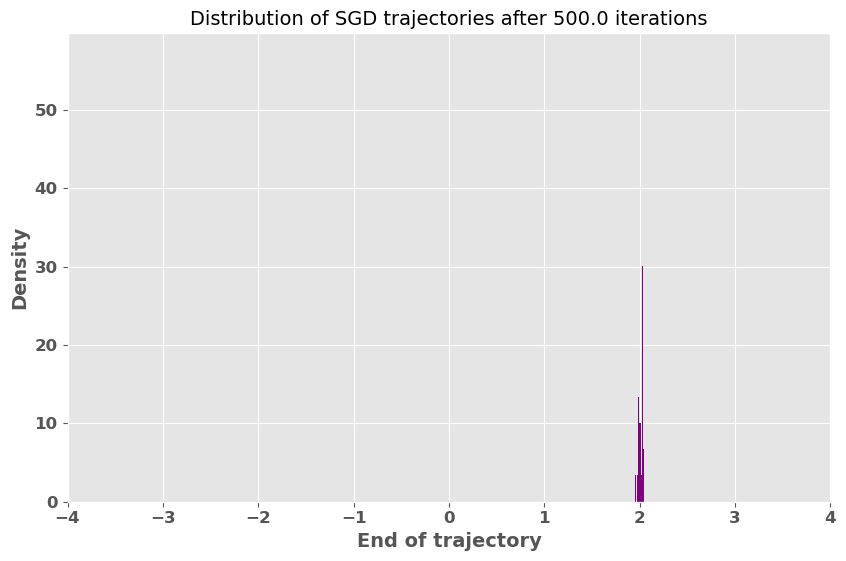

In [83]:
wf = []
for i in range(len(df)):
    wf.append(df["trajectory"][i][-1])
niterations = nsamples/batch_size
plt.hist(wf, bins=50, density=True, color="purple")
plt.xlabel("End of trajectory")
plt.ylabel("Density")
plt.xlim((-wmax, wmax))
plt.title(f"Distribution of SGD trajectories after {niterations} iterations")

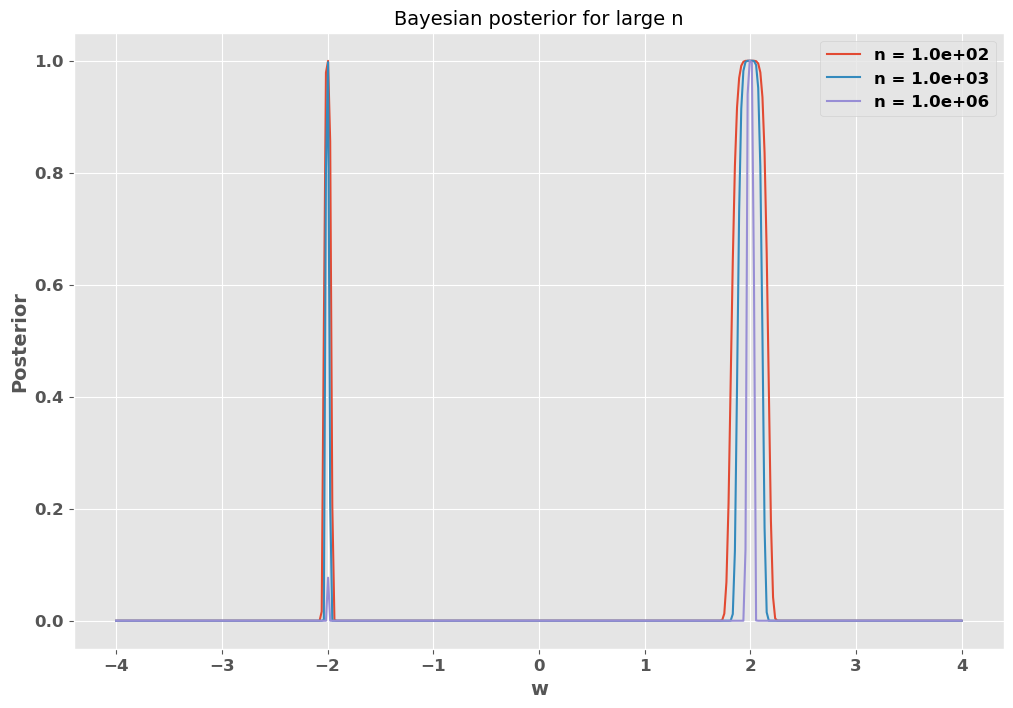

In [7]:
# Exact
n_values = [100, 1000, 1000000]

w = np.linspace(-4, 4, 400)
K_w = (w - w0)**6 * (w + w0)**4
# Plotting the function for different values of n
plt.figure(figsize=(12, 8))

for n in n_values:
    l = np.exp(-n*K_w)
    plt.plot(w, l, label=f'n = {n:.1e}')
plt.title('Bayesian posterior for large n')
plt.xlabel('w')
plt.ylabel('Posterior')
plt.legend()
plt.grid(True)
plt.yscale("linear")  # Using a logarithmic scale for better visualization
plt.show()

# Compute distance to most degenerate point in 1D

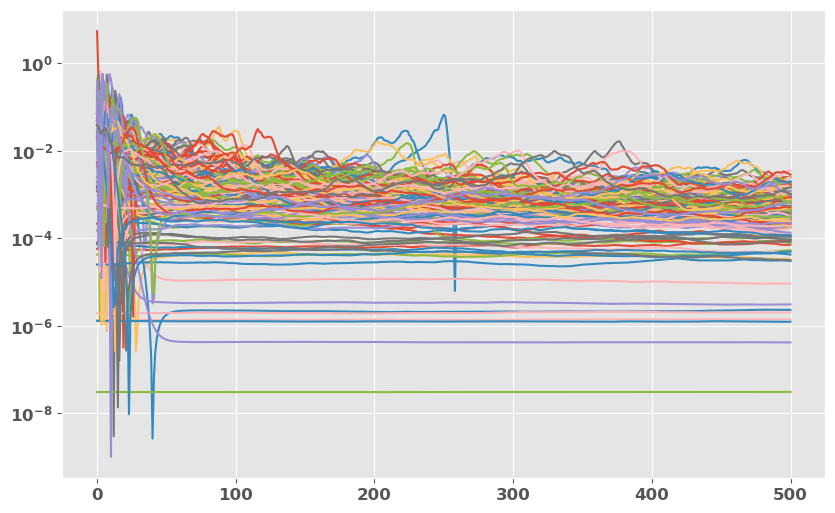

In [22]:
# Get rid of trajetories that diverge. 
niterations = nsamples/batch_size
time = np.arange(0,niterations +1,1)
distance = (trajectories - w0)**2
for i in range(distance.shape[0]):
    plt.plot(time, distance[i,:])
    plt.yscale('log')

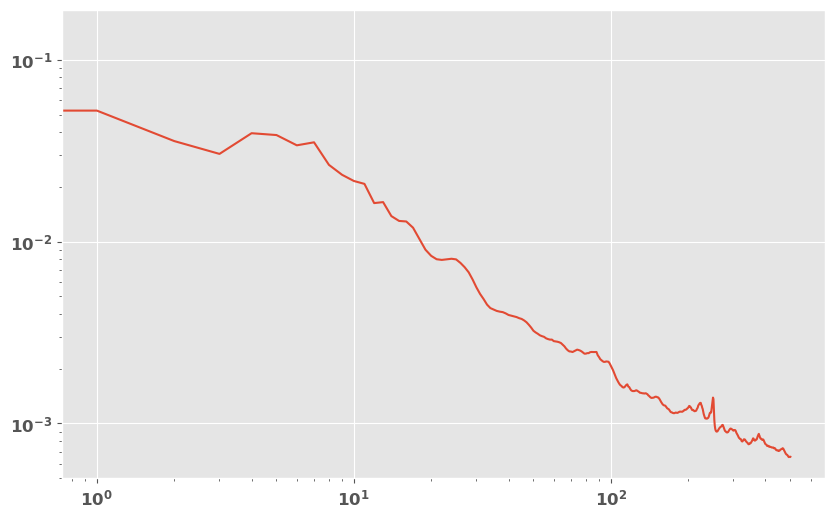

In [26]:
# Plot average distance
mean_distance = np.mean(distance, axis=0)
plt.plot(time, mean_distance)
plt.yscale('log')
plt.xscale('log')

# 2D case

In [127]:
# Initialise
nSGD = 10**3
nsamples = 10**4
shuffle = True
batch_size= 20
momentum = 0.6
lr = 0.01
seed_init = 1
seed_data = 1
wxm = -0.1
wym = 5
d=2
wx_init = torch.tensor(-0.1) 
wy_init = torch.tensor(-5.0)
model = PolyModel2D(seed=seed_init, wxm=wxm, wym=wym, wx_init=wx_init, wy_init = wy_init, d=d)
sgd_runner = SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, seed=seed_data, momentum=momentum, shuffle=shuffle, 
                           batch_size=batch_size, auto=True)
df = sgd_runner.generate_trajectories2d(model)

501


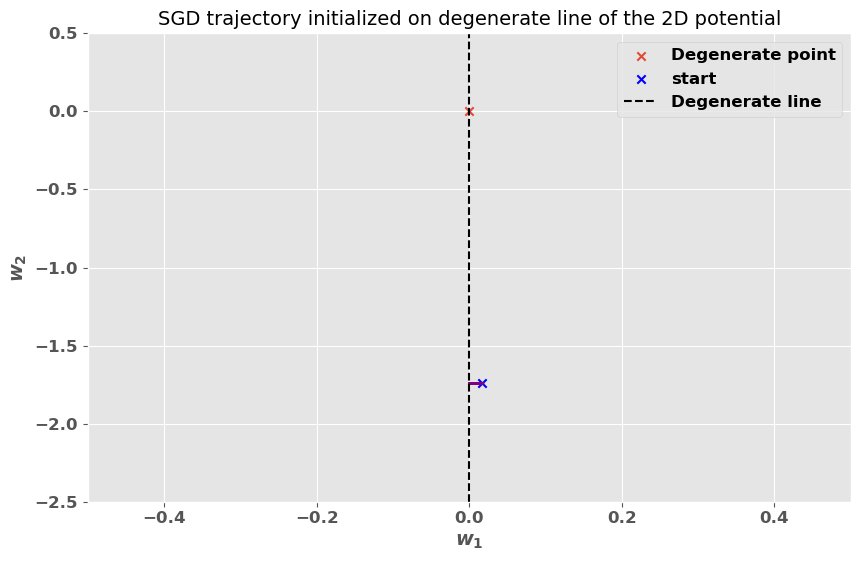

In [90]:
%matplotlib inline
wx = df["trajectory1"][0]
wy = df["trajectory2"][0]
print(len(wx))
fig, ax = plt.subplots()
plt.plot(wx,wy, color='purple')
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.xlim((-0.5, 0.5))
plt.ylim((-2.5, 0.5))
plt.grid(True)
plt.scatter(0,0,marker='x', label="Degenerate point")
plt.scatter(wx[0], wy[0], marker='x', label="start", color='blue')
plt.axvline(x=0, linestyle='--',label = "Degenerate line", color='k')
plt.title("SGD trajectory initialized on degenerate line of the 2D potential")
plt.legend()
plt.show()

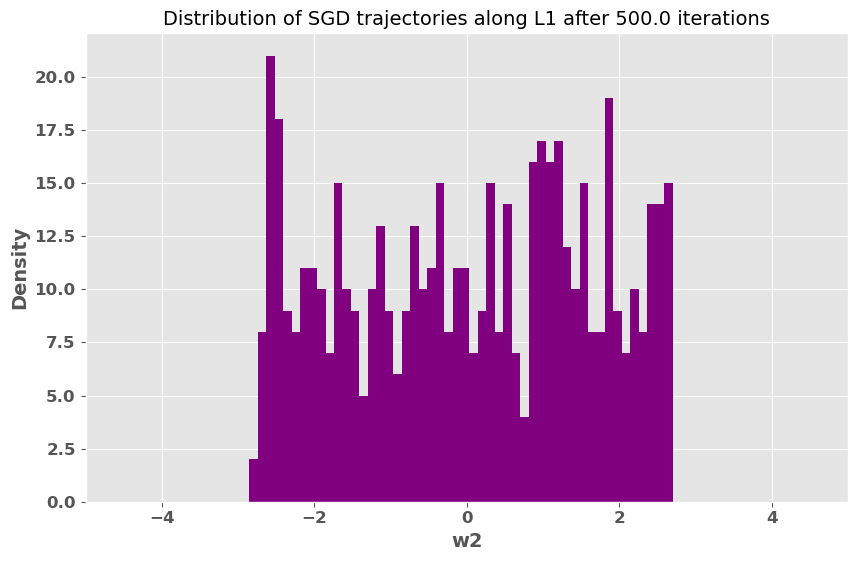

In [91]:
# Histogram of SGD trajectories over the degenerate line
wyf = [0]*nSGD
for i in range(nSGD):
    wyf[i] = df["trajectory2"][i][-1]

%matplotlib inline
niterations = nsamples/batch_size
plt.hist(wyf, bins=50, color='purple')
plt.xlabel("w2")
plt.ylabel("Density")
plt.xlim((-wym, wym))
plt.title(f"Distribution of SGD trajectories along L1 after {niterations} iterations")
plt.show()

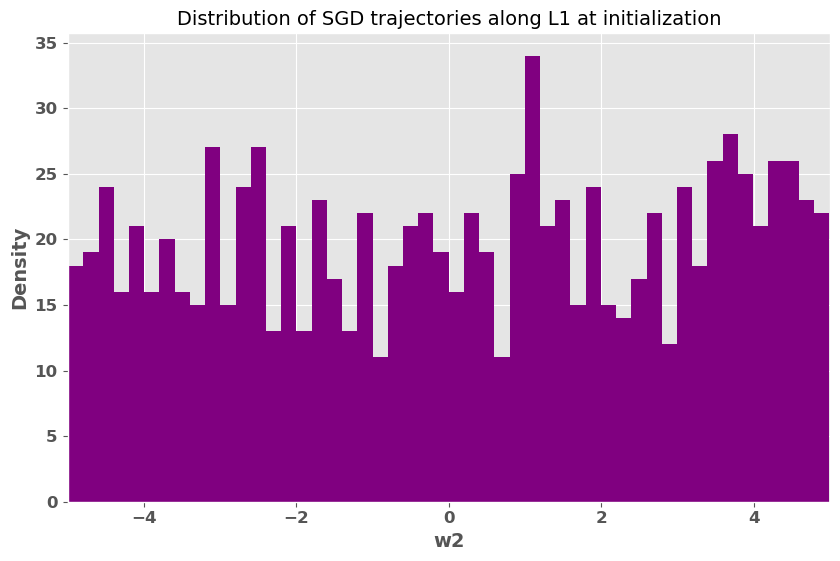

In [92]:
# Histogram of SGD trajectories over the degenerate line
wyf = [0]*nSGD
for i in range(nSGD):
    wyf[i] = df["trajectory2"][i][0]

%matplotlib inline
niterations = nsamples/batch_size
plt.hist(wyf, bins=50, color='purple')
plt.xlabel("w2")
plt.ylabel("Density")
plt.xlim((-wym, wym))
plt.title(f"Distribution of SGD trajectories along L1 at initialization")
plt.show()

# Compute distance to most degenerate point in 2D

In [128]:
# Prepare array
df_clean = df.dropna()
wx = df["trajectory1"].tolist()
wy = df["trajectory2"].tolist()
wx = np.array(wx)
wy = np.array(wy)
W = np.stack((wx, wy), axis=0)
nan_mask = np.isnan(W).any(axis=(0, 2))
W = W[:, ~nan_mask, :]
print(W.shape)

(2, 549, 501)


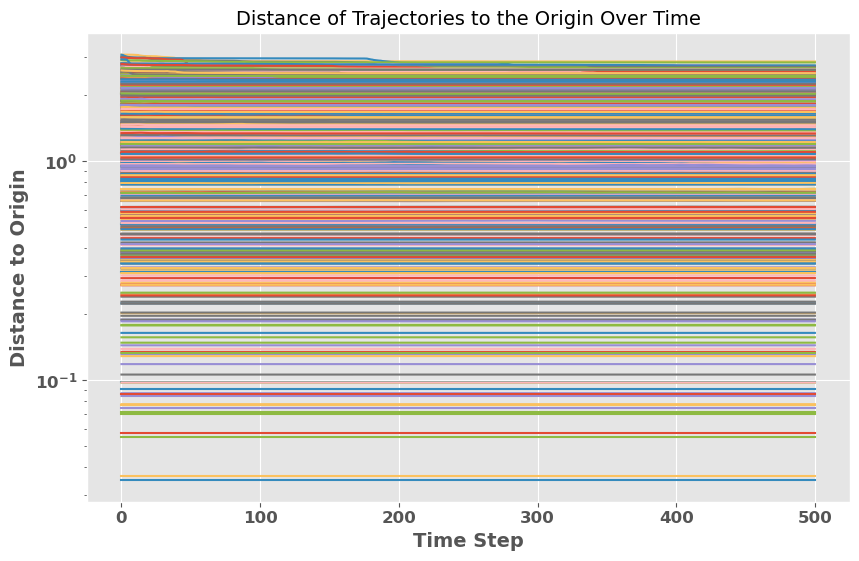

In [129]:
# Extract the x-coordinates and y-coordinates
x_coordinates = W[0]
y_coordinates = W[1]

# Compute the Euclidean distance from each point to the origin (0, 0)
distances = np.sqrt(x_coordinates**2 + y_coordinates**2)

# Plot the distances
time = np.arange(W.shape[2])  # Assuming time steps are sequential integers

for i in range(distances.shape[0]):
    plt.plot(time, distances[i, :])
    plt.yscale("log")

plt.xlabel('Time Step')
plt.ylabel('Distance to Origin')
plt.title('Distance of Trajectories to the Origin Over Time')
plt.show()


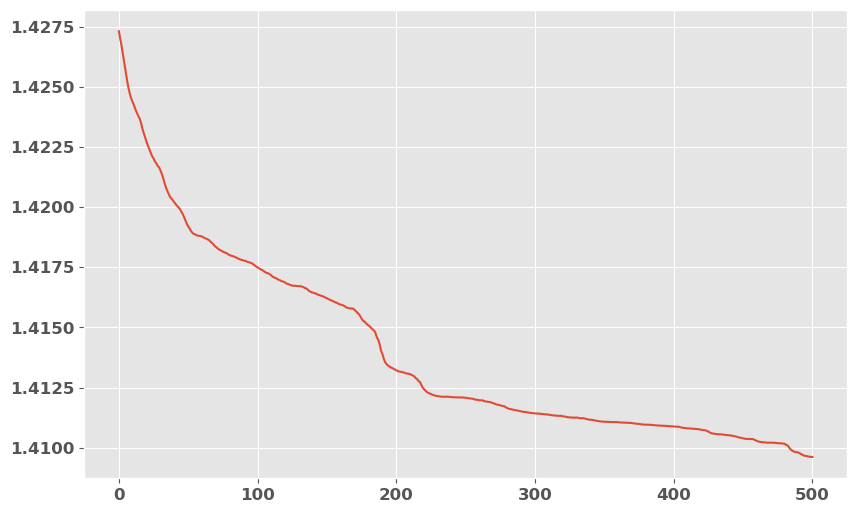

In [132]:
mean_dist = np.mean(distances, axis=0)
plt.plot(time, mean_dist)

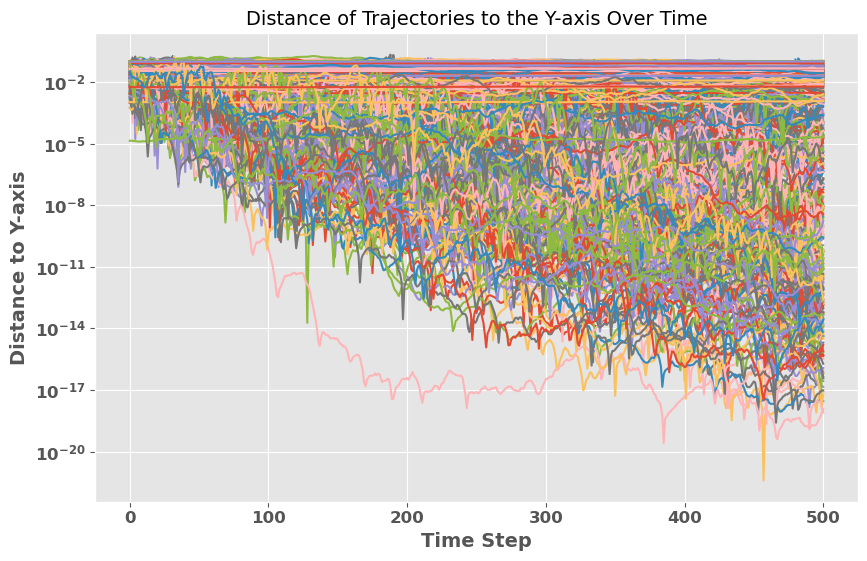

In [133]:
# Distance to L
# Extract the x-coordinates (first row of W)
x_coordinates = W[0]

# Compute the Euclidean distance from each point to the y-axis (x = 0)
# This is simply the absolute value of the x-coordinates
distances = np.abs(x_coordinates)

# Plot the distances
time = np.arange(W.shape[2])  # Assuming time steps are sequential integers

for i in range(distances.shape[0]):
    plt.plot(time, distances[i, :])
    plt.yscale("log")

plt.xlabel('Time Step')
plt.ylabel('Distance to Y-axis')
plt.title('Distance of Trajectories to the Y-axis Over Time')
plt.show()

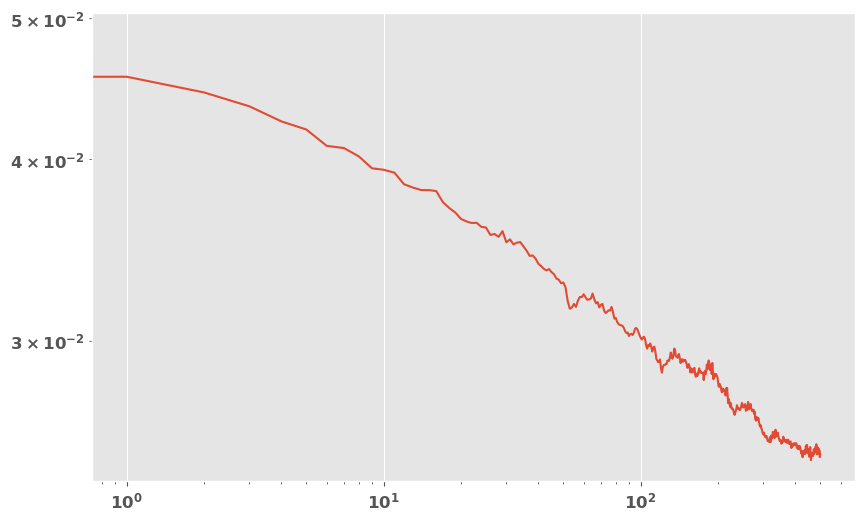

In [135]:
mean_dist = np.mean(distances, axis=0)
plt.plot(time, mean_dist)
plt.yscale('log')
plt.xscale('log')